# **Chap 3: 朴素贝叶斯分类器及其变种**

In [2]:
from sklearn.naive_bayes import CategoricalNB, GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_validate
import numpy as np
from IPython.display import HTML, display

## **1 朴素贝叶斯分类器**

本章将介绍一种基于**贝叶斯理论**的**分类**模型，**朴素贝叶斯**（后文统一写为**NB**）分类器作为一种基础的机器学习模型，原理简单直观  
并且与其他机器学习相比，**NB**将是我们介绍的第一个**生成模型**

### **1.1 贝叶斯方法**

**贝叶斯**是英国数学家，他首先将**归纳推理**用于概率论基础理论，对早期概率论的研究起到了非常大的影响，他对统计推断的主要贡献在于引入**逆概率**的概念

贝叶斯开创了**贝叶斯统计理论**，其中核心的**贝叶斯公式**是**NB**模型的理论核心：
$$
P(y_i|x) = \frac{P(y_i)P(x|y_i)}{P(x)} = \frac{ P(y_i)P(x|y_i) }{ \sum_{i} P(y_i)P(x|y_i) }
$$

理解贝叶斯公式，可以从**先验、似然和后验**三个方面进行，然后我们通过**单词拼写修正算法**的场景加以说明

**(1) 后验 $P(y_i|x)$**

大部分情况下，我们都关心的是**后验概率** $P(y_i|x)$，即当 $x$ 发生时，或观测到 $x$ 时，产生第 $i$ 种结果 $y_i$ 的概率是多少

当掌握了关于 $y$ 的后验概率分布 $P(y|x)$ 后，当给定了获得的观测 $x$，我们就能用 $y^* = \mathop{\arg\max}\limits_{y_i} P(y_i|x)$ 作出预测

如果再注意到：

$$
y^* = \mathop{\arg\max}\limits_{y_i} P(y_i|x) = \mathop{\arg\max}\limits_{y_i} \frac{ P(y_i)P(x|y_i) }{P(x)} = \mathop{\arg\max}\limits_{y_i} P(y_i)P(x|y_i)
$$

这时候，我们**并不关心观测到 $x$ 的概率 $P(x)$**

在单词拼写的场景下，假设算法接收到用户输入的一个错误字符串 $S$，$S$ 不存在于字典中，算法需要判断**用户真正想要输入的单词 $C$ 是什么**，即我们关心概率：
$$
P(\text{用户想要输入的单词}C | \text{用户实际输入的字符串}S)
$$

例如用户错误输入一个字符串 graet，那么他真正想输入的是 great 还是 grant ？哪一个的可能性更大呢？

我们不妨将算法的多个可能猜测记为 $c_1,c_2,\cdots,c_K$，它们属于一个有限且离散的猜测空间 $C$，即合法字典，将用户实际输入的单词记为 $s$，它是算法接收到的观测，则：

$$
P(\text{用户想要输入的单词}C | \text{用户实际输入的字符串}S) = P(c|s)
$$

根据贝叶斯定理，我们有：
$$
P(c|s) \sim P(c)\cdot P(s|c)
$$

**(2) 先验 $P(y_i)$**

**先验概率** $P(y_i)$ 是对不同结果 $y_i$ 的**最朴素的认知**，它是抛掉所有**观测与标签之间因果关系**的一种直观的概率估计

先验概率的计算非常直观，我们可以统计所有的历史数据中各种 $y_i$ 出现的频率，然后将频率作为概率 $P(y_i)$ 的估计

先验概率在某些**“黑箱”场合**下（即我们无法识别到关于 $y$ 有关的观测 $x$ 时），依然是一种有效的估计

例如一个猜测硬币正反面的赌博机，内部受某个机关 $x$ 的控制但我们无法观测到，如果**我们观测了历史 100 次硬币的投掷结果后发现正面向上的概率显著的大于** $0.5$，我们就可以用先验概率 $P(y_i)$ 来做出预测

在单词拼写的场合，**单词表中每个单词** $c$ **在各种文章中出现的频率** $P(c)$ 就可以作为**先验概率**来使用，显然信息 $P(c)$ 在贝叶斯公式中是很有用的：
* 例如对于猜测 great，这个单词的出现频率肯定远远高于其他单词，进而提高 $P(c|s)\sim P(c)\cdot P(s|c)$ 的概率
* 而对于猜测 grant，该单词的出现频率小于 great，在不考虑 $P(s|c)$ 时，$P(c|s)\sim P(c)\cdot P(s|c)$ 的概率值就会小于猜测 great 的
* 而对于那些各种文中出现概率更小的单词 $c$，先验 $P(c)$ 更小，算法就更不可能将 grant 修正为 $c$

但**仅使用先验概率** $P(y_i)$ **就做出决策还不够可靠**，因为我们**忽略了观测到 $x$ 所提供的额外信息**

**(3) 似然 $P(x|y_i)$**

**似然概率** $P(x|y_i)$ 是**给定标签以后特征 $x$ 出现的类条件概率**，它乘以先验 $P(y_i)$ 是**对先验概率的修正**，充分考虑观测值 $x$ 携带的信息，对原有概率做“**违反事实**”的**减弱**或“**顺应事实**”的**增强**：
* 例如先验 $P(y_i)$ 可能很大，但从历史数据统计发现，当标签为 $y_i$ 时，会**观测到特征** $x$ **时的似然** $P(x|y_i)$ **很小**，即在历史数据中，$y_i$ 发生时我们几乎没观测到 $x$ 出现过，此时不经会产生**疑虑**：**当观测到** $x$ **时**，**结果为** $y_i$ **真的可靠吗？**，所以在先验 $P(y_i)$ 基础上乘以“违反事实”的似然 $P(x|y_i)$ 来加以修正，减弱猜测结果为 $y_i$ 的概率
* 反之，先验 $P(y_i)$ 很小时，如果历史数据统计发现，当标签为 $y_i$ 时，会**观测到特征** $x$ **时的似然** $P(x|y_i)$ **很大**，即在历史数据中，$y_i$ 发生时我们都能观测到 $x$ 出现，此时自然会产生**选择偏好**：**当观测到** $x$ **时**，**结果很大可能是** $y_i$，所以在先验 $P(y_i)$ 基础上乘以“顺应事实”的似然 $P(x|y_i)$ 来加以修正，增加猜测结果为 $y_i$ 的概率

似然通过引入观测 $x$ 的信息，来对概率加以修正，这是**归纳推断**的核心，是一种非常有效的手段

在单词拼写的场合，$P(s|c)$ 代表了算法猜测单词为 $c$ 的条件下，用户错误输入为 $s$ 的概率，它可以通过统计历史数据中，用户错误拼写的各种记录估计得到

例如，单词 the 可能是全词典中出现频率最高的单词之一，其先验 $P(c)$ 很大，但**似然的加入使得算法不会把用户输入 graet 修正为 the**，因为似然 $P(s=\text{graet} | c=\text{the})$ 的概率极小（用户将 the 错误拼写为 graet 的可能性几乎为0）

### **1.2 贝叶斯决策**

下面我们简述**NB**解决分类问题的核心思路，我们依然按照机器学习三要素来展开，首先明确，**NB**所解决的问题时**有监督问题**

假设特征空间 $\mathcal{X}=\mathbb{R}^p$，输出空间 $\mathcal{Y}$ 是离散空间，其中每个元素 $y\in \{1,2,\cdots,K\}$，并假设我们采集到历史的观测值 $\{(X_i,y_i)\}_{i=1}^{N}$

假设特征 $x$ 和标签 $y$ 的联合概率分布为满足：
$$
(x,y) \sim P(x,y)
$$

我们的目标是学习预测函数 $y=f(x)$，需要注意，$x$ 可以是**连续变量**，也可以是**离散变量**（例如城市、性别等变量）

**(1) 模型**

在上一节的讨论中，我们已经对贝叶斯方法的使用较为清晰，我们的核心是想通过数据学习到联合概率分布 $P(x,y)$，然后基于联合概率 $P(x,y)$ 做出决策

因此在这里，需要引入**判别模型**和**生成模型**的概念：
* 判别模型通过学习给定 $x$ 以后 $y$ 的条件概率分布 $P(y|x)$ 来预测 $y$，模型是对**条件概率分布**建模，例如之前介绍的逻辑回归，和之后将介绍的决策树、SVm等都是判别式模型
* 生成模型通过学习 $x$ 和 $y$ 的联合概率分布 $P(x,y)$。并依此计算 $P(y|x)$ 来预测 $y$，模型是对**联合概率分布**建模，**NB**就是典型的生成式模型，**生成模型因为学习到了联合分布、即数据产生的机制，故此得名**

下图用一组简单的样本，说明了**生成模型和判别模型建模方式上的区别**：

In [5]:
display(HTML("<img src='./source/Chap3/生成模型和判别模型.png' style='width: 1000px' align='left'/>"))

前面已经提到，**贝叶斯模型的决策用后验概率** $P(y|x)$ 进行，不过是**基于联合概率** $P(x,y)$ **来计算**：

$$
y^* = f(x) = \mathop{\arg\max}\limits_{y\in \mathcal{Y}} P(y|x) = \mathop{\arg\max}\limits_{y\in \mathcal{Y}} P(x,y) = \mathop{\arg\max}\limits_{y\in \mathcal{Y}} P(y)P(x|y)
$$

想要计算联合概率 $P(x,y)$，我们需要的**参数**包括：
* 先验概率：$P(y=k),k=1,\cdots,K$，这里包含了 $K$ 个概率参数
* 似然：$P(x|y=k) = P(x_1,\cdots,x_p|y=k)$，出于简化仅考虑离散特征场合，假设每个特征 $x_i$ 可能的取值有 $S_i$ 个，则这里包含了 $K\times \prod_{i=1}^{p}S_i$ 个概率参数

因此，一个离散特征下的**NB**模型，参数空间 $\Theta$ 为：

$$
\Theta = \{P(y=k),P(x_1,\cdots,x_p|y=k),k=1,\cdots,K  \}
$$

注意到，参数空间 $\Theta$ 的大小为 $|\Theta| = K + K\times \prod_{i=1}^{p}S_i$，这**随着特征数量** $p$ 是**指数阶增长**的

为了简化模型、减小上述参数的估计难度，**NB**采用了**属性条件独立性假设**，即**给定 $y=k$ 后，属性之间相互独立**

$$
P(x_1,\cdots,x_p|y=k) = \prod_{i=1}^{p} P(x_i|y=k)
$$

**朴素**贝叶斯名字的由来，就在于**NB牺牲了各特征（属性）之间的关联性，认为每个属性独立地对结果 $y$ 造成影响**

此时，我们的决策函数发生变化：

$$
y^* = f(x) = \mathop{\arg\max}\limits_{y\in \mathcal{Y}} P(y|x) = \mathop{\arg\max}\limits_{y\in \mathcal{Y}} P(y)P(x|y) = \mathop{\arg\max}\limits_{y\in \mathcal{Y}} P(y) \prod_{i=1}^{p}P(x_i|y)
$$

参数空间 $\Theta$ 变化为：
* 先验概率：$P(y=k),k=1,\cdots,K$，这里包含了 $K$ 个概率参数
* 似然：$P(x_i|y=k),i=1,\cdots,p.k=1,\cdots,K$，在**属性条件独立性假设**下，这里包含了 $K\times \sum_{i=1}^{p}S_i$ 个概率参数

现在，总参数量变为线性增长的 $|\Theta| = K + K\times \sum_{i=1}^{p}S_i$，最后，我们可以写出模型的假设空间 $\mathcal{F}$了：

$$
\mathcal{F} = \{f_\theta|y=f_\theta(x)=\mathop{\arg\max}\limits_{y\in\mathcal{Y}} P(y)\prod_{i=1}^{p}P(x_i|y), \theta = \{ P(y=k), P(x_i|y=k),i=1,\cdots,p,k=1,\cdots,K \}\in \Theta \}
$$

**(2) 策略**

上述讨论中我们已经默认给定了决策函数 $f$ 为**求解后验概率的极大值点**，一个自然的问题是：**为什么选择后验密度的极大值点作为决策？它的理论依据是什么？这样的决策是最优的吗？在何种意义上最优？**

事实上，**NB**使用**0-1决策损失**来构造期望风险函数：

$$
L\left(y,f(x)\right) = \left\{
\begin{array}{ll}
0, & y = f(x) \\
1, & y \ne f(x)
\end{array}
\right.
$$

期望风险函数 $R_{exp}(f)$ 为：
$$
R_{exp}(f) = \mathbb{E}_{P}\left[ L(y,f(x)) \right] = \int_{\mathcal{X}\times \mathcal{Y}} L(y,f(x)) P(x,y) dxdy = \int_{\mathcal{X}\times \mathcal{Y}} \mathbb{I}(y\ne f(x)) P(x,y) dxdy
$$

因此，对于给定联合概率 $P(x,y)$，或者说给定参数 $\Theta_0$，模型的策略是找关于期望风险 $R_{exp}(f)$ 的极小值点：

$$
f^* = \mathop{\arg\min}\limits_{f} R_{exp}(f)
$$

即**已知概率分布的情况下，应该如何确定决策函数呢**

注意这里与**模型**部分中的**贝叶斯决策过程**的区别和联系：
* 对每个 $f$，给定 $x$，$f(x)$ 通过贝叶斯决策将实例分到**后验概率最大的类中**，这是 $\mathop{\arg\max}_{y\in\mathcal{Y}}$ 的含义
* 最优决策函数 $f^*$ 是在**0-1损失**下，使得**期望风险最小化**，这是 $\mathop{\arg\min}_{f}$ 的含义

下面的证明将展示**上述两条实质上是等价的**，对于给定的 $x_0$，考虑单样本的损失 $r(x_0)$:
$$
r(x_0) = \mathbb{E}_{y|x=x_0}\left[L(y,f(x)) | x=x_0  \right]
$$

根据条件期望的相关公式，期望风险 $R_{exp}(f)$ 满足：
$$
R_{exp}(f) = \mathbb{E}_{\mathcal{X},\mathcal{Y}}\left[ L(y,f(x)) \right] = \mathbb{E}_{\mathcal{X}}\left[ \mathbb{E}_{\mathcal{Y} | \mathcal{X}} \left[L(y,f(x)) | x  \right] \right]
= \mathbb{E}_{\mathcal{X}} \left[ r(x) \right]
$$

注意，**使期望 $R_{exp}(f) = \mathbb{E}_{\mathcal{X}} \left[ r(x) \right]$ 最小化，可以转换为寻找 $r(x)$ 使其在每个点 $x$ 处 $r(x)$ 最小化**

上面的断言是显然的，如果能找到 $r(x)$ 使得在每个点 $x$ 处 $r(x)$ 最小，那么期望 $R_{exp}(f)$ 也一定取到最小值，事实上，$r(x)$ 可以写出：

$$
r(x) = \sum_{y\in\mathcal{Y}} \mathbb{I}(y\ne f(x))P(y|x) = \sum_{y\in\mathcal{Y}} \left[1 - \mathbb{I}(y= f(x))\right] P(y|x)  =  1 - \sum_{y\in\mathcal{Y}} \mathbb{I}(y=f(x))P(y|x)
$$

如果假设 $\mathcal{Y}$ 是离散空间 $\{1,2,\cdots,K\}$，则

$$
r(x) = 1 - \sum_{k=1}^{K} \mathbb{I}(f(x) = k)P(y=k|x)
$$

注意到：
$$
\min r(x) \quad \Leftrightarrow \quad \max \sum_{k=1}^{K} \mathbb{I}(f(x) = k)P(y=k|x)
$$

因此，对每个 $x$ 而言，最优的决策函数 $f^*(x)$ 为：
$$
f^*(x) = \mathop{\arg\max}\limits_{y\in\mathcal{Y}} P(y|x)
$$

即对每个样本 $x$，**决策函数 $f$ 应该选择使得后验概率 $P(y|x)$ 最大的类别标记**

或者反过来说，我们就能回答**策略**部分开头的问题：
* **选择后验概率密度的极大值点作为决策有理论依据**，它建立在**0-1决策损失**的期望损失框架下
* 这样的决策函数确实是最优的，它的最优性在使用**0-1决策损失**来刻画期望损失时成立

**(3) 算法**

接下来就是参数估计的任务了，我们的决策函数 $f$ 为：
$$
y = f(x) = \mathop{\arg\max}\limits_{y\in\mathcal{Y}} P(y)\prod_{i=1}^{p} P(x_i|y)
$$

假设第 $i$ 个特征 $x_i$ 的取值集合 $A_i$ 为 $\{a_{i1},a_{i2},\cdots,a_{iS_i}  \}$，即 $|A_i| = S_i$，则**待估计的参数**为：
* $K$ 个先验概率：$P(y),y\in\mathcal{Y}$
* $K\times\prod_{i=1}^{p}S_i$ 个似然：
$$ P(x_i = a_{ij}|y),\quad i=1,\cdots,p,j=1,\cdots,S_i,y\in\mathcal{Y} $$

事实上，在**模型**和**策略**部分，我们略去了讨论**经验风险 $R_{emp}(f)$ 替代期望风险 $R_{exp}(f)$ 求解函数空间 $\mathcal{F}$ 中关于参数 $\Theta$ 的最优化问题**，这一部分的讨论是平凡的

在实际过程中，我们使用**极大似然估计法**从历史的训练集中，估计得到参数 $\Theta$，在**离散随机变量场景**下，就是**用频率估计概率**：

* 先验概率的估计：
$$
P(y=k) = \frac{1}{N} \sum_{i=1}^{N}\mathbb{I}(y_i = k),\quad k=1,2,\cdots,K
$$

* 似然的估计：
$$
P(x_i = a_{ij}|y=k) = \frac{ \sum_{t=1}^{N}\mathbb{I}(x_i^{(t)} = a_{ij},y_t = k) }{ \sum_{t=1}^{N} \mathbb{I}(y_t = k) },\quad i=1,\cdots,p,j=1,\cdots,S_i,k=1,\cdots,K
$$

接下来，对于新的样本 $x$，我们便能利用先验概率和似然计算它属于每个类别 $k$ 的后验概率 $P(y=k|x)$，并利用决策函数 $f^*(x) = \mathop{\arg\max}\limits_{y\in\mathcal{Y}} P(y|x)$ 做出预测

### **1.3 Laplace修正**

直接使用上一节中的公式来估计似然可能会出现问题

* 假如对于某个类别 $y=k$，在历史数据中，某个特征 $x_i$ 的取值 $a_{ij}$ 在该类别 $y=k$ 下从来没有出现过，则似然 $P(x_i=a_{ij}|y=k) = 0$
* 此时，带入后验概率的公式 $P(y=k)\prod_{i=1}^{p}P(x_i=a_{ij}|y=k)$，后验概率会直接等于 $0$
* 如果其他项的似然和先验概率很大，仅因为历史样本中缺少一条这样的记录，就使得后验概率等于 $0$，这显然是不合理的

这种**某个特征取值在训练集中没有与某个类同时出现过**的问题，在**测试集上可能会导致大面积后验概率计算结果为 $0$ 的问题**，为此，我们需要引入**Laplace平滑**，对先验和似然做一些修正

为了避免其他特征维度携带的信息被训练集中未出现的属性值**抹去**，在估计概率时通常进行**Laplace修正**，即在**各个取值的频数上赋予一个平滑参数** $\lambda\geq 0$：

* 先验概率的修正：
$$
P_\lambda(y=k) = \frac{1}{N + K\lambda} \left[ \lambda + \sum_{i=1}^{N}\mathbb{I}(y_i = k)\right],\quad k=1,2,\cdots,K
$$

* 似然的估计：
$$
P_\lambda(x_i = a_{ij}|y=k) = \frac{\lambda + \sum_{t=1}^{N}\mathbb{I}(x_i^{(t)} = a_{ij},y_t = k) }{ S_i\lambda + \sum_{t=1}^{N} \mathbb{I}(y_t = k) },\quad i=1,\cdots,p,j=1,\cdots,S_i,k=1,\cdots,K
$$

引入修正后，能够避免出现先验概率和似然等于 $0$ 的情况，同时修正的引入需保证**概率和等于1**

### **1.4 扩展和总结**

#### **1.4.1 推广到连续特征场合**

前面所涉及到的所有参数估计，都假设了 $x_i$ 取值自离散特征集 $A_i = \{a_{i1},a_{i2}\cdots,a_{iS_i}\}$，如果特征 $x_i$ 取值自连续型随机变量，该如何处理呢？

事实上，在连续性场合，上述理论框架不需要进行任何改变，我们只需要**假定连续型变量似然满足的分布**即可：
$$
y = f(x) = \mathop{\arg\max}\limits_{y\in\mathcal{Y}} P(y)\prod_{i=1}^{p}P^{(i)}(x_i|y)
$$

其中，$P^{(i)}(x|y)$ 表示第 $i$ 个连续变量特征在条件 $y$ 下的条件概率密度，通常会假设其满足**高斯分布**：
$$
P^{(i)}(x|y=k) \sim N(\mu_{i,k},\sigma_{i,k}^2),\quad i=1,2,\cdots,p,k=1,\cdots,K
$$

此时得到的模型称为**高斯朴素贝叶斯分类器**，常见的假设还有**两点分布**，**多项式分布**等，我们将在**第三节**看到这些方法的比较

连续型变量场合下的参数估计，例如高斯分布的均值和方差，仍然使用**极大似然估计方法**

#### **1.4.2 优点和缺点**

**(1) 优点**
* **NB**做出了**属性之间条件独立**的假设，当实际数据呈现该特点时，其分类性能往往优于其他方法
* 操作简单，只需要计算先验概率和似然
* 无调节算法的超参数
* 可以进行**查表**、**懒惰学习**和**增量学习**：
    * 可以用**NB**估计得到的先验概率和似然事先存储，这样在预测时只需要**查表**就可以获得预测
    * 如果任务数据频繁更新，可以使用**懒惰学习**的方法，先不进行训练，等收到**预测请求**时，再根据当前请求，计算所需要的先验概率和似然
    * 如果训练集数据量不断增加，则可以再现有估值的基础上，**仅对新增样本的特征所涉及的概率估计**进行计数修正（调整分子、分母的频数）就可实现**增量学习**，完成模型更新
* **NB**由于没有在样本上进行任何**代数运算**（有别于**回归类**方法、**SVM**等），因此对**异常值不敏感**，方法比较鲁棒

**(2) 缺点**
* **属性之间条件独立**的假设同时带来了缺点，如果实际数据不满足该特点，则模型的参数估计是有偏的
* 而**这个假设在实际中往往不成立**，因此在**特征数量比较多**或者**特征之间相关性较大**时，**NB**的分类效果不理想

----

## **2 半朴素贝叶斯方法**

### **2.1 独依赖估计ODE**

为了降低贝叶斯公式中估计后验概率的难度，**NB**采用了**属性条件独立假设**，即：
$$
P(x_1,\cdots,x_p|y) = \prod_{i=1}^{p}P(x_i|y)
$$

当数据的真实分布不满足上面的假设，尤其是当**特征数量比较多**，**特征之间的相关性较大**时，**NB**的效果会大打折扣

对**属性条件独立假设**一定程度的放松，由此产生了一类**半朴素贝叶斯分类器**，半朴素贝叶斯分类器最常用的一种策略是**独依赖估计**（ODE：One-Dependent Estimator）

**ODE**假设每个特征 $i$ 的**似然**在类别 $y$ 之外**最多仅依赖一个其他特征**，记为 $pa_i$，即：

$$
P(y|x) \propto P(y,x_{pa_i})\prod_{i=1}^{p}P(x_i|y,x_{pa_i})
$$

其中，$pa_i$ 称为特征 $i$ 的**父属性**，基于ODE，人们提出了各种**NB**的变种方法，下面介绍**SODE**，**AODE**和**WAODE**三类

### **2.2 方法变种**

#### **2.2.1 SODE**

如果对每个特征 $i$ 其父属性 $pa_i$ 已知，则我们可以直接使用**ODE**中的模型计算相应的似然，从而估计后验概率，求解得到决策函数 $f$，然而事实上，**父属性 $pa_i$ 未知**，因此**ODE**需要解决的问题就是**如何确定每个特征 $i$ 的父属性**

**SODE**方法采用最直接的方法，假设所有特征都依赖于同一属性，称为**超父**（super-parent)，记为 $pa$

$$
P(y|x) \propto P(y,x_{pa}) \prod_{i=1}^{p}P(x_i|y,x_{pa})
$$

参数的估计依然采用**极大似然估计方法**，前面提到的**Laplace平滑**方法也可以引入

**SODE**的示意图如下所示：

<img src="./source/Chap3/SODE.png" style="width: 400px" align="left"/>

进一步思考，**实际建模中，超父 $pa$ 也是未知的**，那么如何选择**超父**呢？我们可以使用**交叉验证法**（CV：**Cross-Validation**）

#### **专题：交叉验证法**

在机器学习建模过程中，我们经常会遇到**模型选择**，**模型对比**以及**模型超参数调优**等问题，**交叉验证**提供了一种模型配置调优的方案

在构造一个机器学习模型 $M$ 时，我们一般只能获得历史数据作为训练数据集 $D_{train}$，并希望 $M$ 在未来的测试数据集 $D_{test}$ 上表现良好，但一个显然的问题是：
* 训练模型时，$D_{test}$ 未知，那我们如何**预先评估** $M$ 在测试集上的性能呢？
* 真实商业环境中，$M$ 需要部署上线才能开始对测试数据进行预测，并开始进行相应评估，**如果不幸模型在测试集上的性能出现异常，这种损失是不可估量的**

为此，我们希望利用某种方法，在模型 $M$ 部署前，**仅用手头上已有的历史训练集** $D_{train}$ **对模型未来的表现做出估计**

本质上，我们最主要担心的是模型出现了**过拟合**问题，即 $M$ 在训练的数据 $D_{train}$ 上性能良好，但在 $D_{train}$ 之外的数据性能大打折扣

一种最简单的方法是，我们**将** $D_{train}$ **中的数据留出一部分用于评估，这部分样本不参与训练，它们只用于评估**，用来**模拟** $M$ **在测试集上的表现**，我们称这部分数据为**验证集** $D_{valid}$，如下图所示：

<img src="./source/Chap3/交叉验证.png" style="width: 800px" align="left"/>

由于 $M$ 在训练阶段从未见到数据集 $D_{valid}$，那么在**训练集和测试集数据分布相同的假设下**，$M$ 在 $D_{valid}$ 上性能的评估结果将具有参考意义：
* 如果发现 $M$ 在 $D_{train}$ 上性能很高，却在 $D_{valid}$ 上性能很差，可以预见模型可能出现了**过拟合**，则它在 $D_{test}$ 上的性能也不会好，模型不应该上线

**交叉验证能很好的帮助我们完成模型的选择和超参数的选择**，例如：
* 模型选择：有两个模型 $M_1$ 和 $M_2$，它们在训练集上的性能很接近，该选择谁呢？这时候可以**关注它们在验证集** $D_{valid}$ **上的性能**，选择泛化能力更强的模型
* 超参数选择：模型 $M$ 有一个**超参数** $\lambda$ 需要确定，可以设置不同的 $\lambda$ 观察模型在 $D_{valid}$ 上的性能，选择性能最强时对应的 $\lambda$
  * **超参数**：指**并非在模型求解阶段确定的其他一切可配置的模型参数**，超参数**可能是数值，也可能是非数值**（例如求解所用的优化算法，SODE超父的选择都算超参数），**超参数是模型结构的一部分**
  * Lasso和Ridge方法中，L1，L2惩罚项前面的惩罚系数 $\lambda$ 就是一个超参数，梯度下降算法中学习率 $\eta$ 也属于超参数
  * 回归模型中的回归系数 $\beta$ 不是超参数

在机器学习的项目实践过程中，请注意:**在学习阶段中我们并非处在真实的业务场景，所以很大可能我们能够直接获得测试数据集，但模型选择和模型超参数的调整永远不能在测试数据集上进行，这样做没有意义**

上述的验证方法会造成一个问题：$D_{valid}$ 作为历史数据却没有参与训练，这如果在**样本量较少的时候**会造成**浪费**，一部分历史的信息被我们抛弃了

解决的思路是使用**K折交叉验证**（**K-Folds CV**）:
* 我们将数据集 $D_{train}$ 较为均匀的切分为 $K$ 份，每次用其中的 $K-1$ 份参与训练，剩下的一份作为验证集
* 在 $K$ 轮后，我们获得了模型在整个数据集 $D_{train}$ 上的**包外估计**（**out-of-folds**），即我们用 $M$ 在 $D_{train}$ 上预测，而每次预测的那部分数据没有参与训练
* 模型的**包外估计**性能能作为模型在测试集上性能的估计
* K折交叉验证充分利用整个训练集样本，评估结果的可靠性更强

K折交叉验证的示意图如下，下面展示的是4折交叉验证：

<img src="./source/Chap3/K折交叉验证.png" style="width: 1000px" align="left"/>

关于**K折交叉验证**的一些细节，再做一点补充说明：
* **K折叠交叉验证的包外预测是在整个训练集上完成的**，评估性能时直接与 $y_{train}$ 进行对比
* **K折交叉验证**后会得到 $K$ 个模型 $M_1,\cdots,M_K$，在使用时，可以考虑：
  * **仅利用包外估计的性能确定模型超参数**，然后用该超参数配置模型，让模型在整个训练集 $D_{train}$ 上重新学习，然后部署
  * 直接使用 $K$ 个模型进行部署，对于分类任务，每次预测采用 $K$ 个模型投票的结果，对于回归任务，可以取 $K$ 个模型预测的平均值
* **随着** $K$ **的增大**，**K折交叉验证方法的计算量会快速增加**
* 极端情况下，假设样本量 $|D_{train}| = N$，则可以进行**N折交叉**，即每次只保留一个样本作为验证，此时该方法称为**LeaveOneOut**

我们可以利用`sklearn`中的`KFolds`方法来实现一个自定义的**K折交叉验证**方法

In [2]:
def CrossValidation(model, metric, X : np.ndarray, y : np.ndarray, K : int=5):
    """
    CrossValidation(model, K : int=5)
        K折交叉验证评估
    
    Parameters
    ----------
    model : Any
        待评估的模型
    metric : Callable
        模型性能的度量函数，回归场合可以使用`MSE`，分类场合可以使用准确率
    X : np.ndarray
        训练集特征
    y : np.ndarray
        训练集标签
    K : int, optional
        折数，默认值为`5`
    
    Return
    ----------
    score : float
        模型的包外预测性能
    """
    # 初始化交叉验证分割器
    spliter = KFold(n_splits=K)
    # 初始化包外预测
    oof_pred = np.zeros_like(y) # out-of-folds

    # 循环对每一折进行训练和评估
    for train_idx, valid_idx in spliter.split(X):
        # 选择相应的训练集和验证集
        x_train, y_train = X[train_idx], y[train_idx]
        x_valid, y_valid = X[valid_idx], y[valid_idx]

        # 训练模型
        model.fit(x_train,y_train)

        # 在包外做出预测
        oof_pred[valid_idx] = model.predict(x_valid)

    # 评估模型性能
    score = metric(y,oof_pred)
    return score

`sklearn`中含提供了很多其他的交叉验证的分组方法，具体可见[Visualizing cross-validation behavior in scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

#### **2.2.2 AODE**

**平均独依赖估计AODE**是一种**集成学习**机制，它尝试**将每个属性作为超父**建模，然后将学习得到的 $p$ 个**SODE**模型取平均，作为最终模型

$$
P(y|x) \propto \sum_{j : |D_{x_j}| \geq m} \left[ P(y,x_j)\prod_{i=1}^{p} P(x_i|y,x_j) \right]
$$

其中，$D_{x_j}$ 表示考虑第 $j$ 个特征为超父时，其取值的样本集合，我们希望样本量应该超过某一个阈值 $m$，以保证概率估计的合理性，否则不参加计算

**AODE**相比**SODE**的好处在于，我们**无需考虑模型的选择问题**，即不需要确定 $pa$，此时每个特征都是超父

**AODE**的示意图如下所示：

<img src="./source/Chap3/AODE.png" style="width: 800px" align="left"/>

#### **2.2.3 WAODE**

**AODE**分别假设每个特征为超父，并将这些模型取线性组合作为最终模型，但它同时假定了**每个特征作为超父的权重相同**

在实际问题中，不同属性对分类预测结果影响的权重往往是不同的，因此可以考虑**对AODe**进行适当的调整，引入**加权平均独依赖估计WAODE**

$$
P(y|x) \propto \sum_{j : |D_{x_j}| \geq m} w_j\cdot \left[ P(y,x_j)\prod_{i=1}^{p} P(x_i|y,x_j) \right]
$$

其中，$w_j\geq 0$表示权重，自然地我们会发问，**如何确定权重 $w_j$$呢？**

通常，我们会用特征 $i$ 与目标变量 $y$ 之间的**相关性**来确定权重，而相关性的度量我们使用**信息论中的互信息** $w_i = I(y;x_i),i=1,\cdots,p$

互信息的概念来自于**熵**，设 $X$ 为离散型随机变量，概率分布满足 $P(X=x_i) = p_i,i=1,\cdots,n$，则 $X$ 的熵定义为：
$$
H(X) = -\sum_{i=1}^{n}p_i\log(p_i)
$$

注意到：
* 当 $p_i = 0$ 时，$p_i\log p_i = 0$
* 熵是随机变量不确定性的一种度量
* 熵越大，随机变量的不确定性越大
* 可以验证：$0\leq H(X) \leq \log(n)$

例如，考虑二值随机变量 $X\in \{0,1\}$，并假定：
$$
P(X=1) = p,\quad P(X=0) = 1-p
$$

此时，$X$ 的熵为：
$$
H(X) = -p\log(p) - (1-p)\log(1-p)
$$

可以验证下面两点：
* 当 $p=0$ 或者 $p=1$ 时，熵为 $0$，随机变量完全失去随机性
* 当 $p=0.5$时，$H(X)$ 取最大值，随机变量的不确定性也最大

下一个概念，我们需要引入**条件熵**，设有随机变量对 $(X,Y)$，其联合概率分布为：
$$
P(X=x_i,Y=y_j) = p_{ij},\quad i=1,\cdots,n;j=1,\cdots,m
$$

我们用 $H(X|Y=y)$ 表示**给定 $Y=y$ 时，随机变量 $X$ 的条件熵**：
$$
H(X|Y=y_j) = -\sum_{i=1}^{n} p_{i|j}\log(p_{i|j}),\quad j=1,\cdots,m
$$

用 $Y$ 的边际分布对上式加权，得到**全分布的条件熵** $H(X|Y)$：
$$
H(X|Y) = \sum_{j=1}^{m} P(Y=y_j)H(X|Y=y_j)
$$

**条件熵 $H(X|Y)$ 衡量了 $Y$ 已知的条件下，随机变量 $X$ 不确定性的大小**，最后，我们可以引入**互信息（信息增益）**：
$$
I(X;Y) = H(X) - H(X|Y)
$$

**互信息 $I(X|Y)$ 表示得知变量 $Y$ 的信息，使得随机变量 $X$ 的信息的不确定性减少的程度**

所以，$I(X;Y)$ 适合用来描述随机变量 $Y$ 提供的关于 $X$ 的信息量的大小，他经常用来作为**相关性的度量**

综上讨论，在**WAODE**中，将 $I(y;x_i)$ 作为权重 $w_i$ 来使用是合适的，**WAODE**的示意图如下所示：

<img src="./source/Chap3/WAODE.png" style="width: 800px" align="left"/>

----

## **3 方法比较**

### **3.1 sklearn中的朴素贝叶斯方法**

`sklearn`中提供了多种**NB**方法的实现，它们分别对**似然函数的分布**做出了不同假设，包含：
* `GaussianNB`：Gauss朴素贝叶斯
* `MultinomialNB`：多项分布朴素贝叶斯
* `ComplementNB`：补集朴素贝叶斯
* `BernoulliNB`：伯努利朴素贝叶斯
* `CategoricalNB`：类别朴素贝叶斯

接下来，我们仅对每个**NB**方法的核心假设做出解释，详细的介绍请参考官方文档：[Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes)

**(1) GaussianNB**

Gauss朴素贝叶斯应用范围最广，它假设似然函数服从一般的Gauss分布：

$$
P(x_i|y) \sim N(\mu_y,\sigma_y^2)
$$

均值和方差参数的估计使用**极大似然估计方法**

**(2) MultinomialNB**

多项分布朴素贝叶斯是在**文本分类中**最经典的朴素贝叶斯模型之一，它的输入特征一般是**语句分词的词频统计值**

对每个类别 $y\in\mathcal{Y}$，多项分布朴素贝叶斯的参数向量是 $\theta_y = \{\theta_{y1},\cdots,\theta_{yp}\}$，假设似然服从该多项分布：
$$
P(x_1,\cdots,x_p|y) \sim \text{Multinomial}(\theta_y)
$$

然后，给定新的样本，就可以用多项分布的概率密度公式计算似然 $P(x_1,\cdots,x_p|y)$ 了

**(3) ComplementNB**

补集朴素贝叶斯方法是对**多项分布朴素贝叶斯**方法的补充，主要用于处理**样本不平衡数据集问题**

具体来说，`ComplementNB`使用来自每个类的补集的统计数据来计算模型的权重。`ComplementNB`的实证结果表明，其参数估计比`MultinomialNB`的参数估计更稳定

**(4) BernoulliNB**

伯努利朴素贝叶斯假设每个特征 $i$ 的似然服从两点分布：
$$
P(x_i|y) = P(x_i = 1|y)x_i + \left[1 - P(x_i = 1|y)\right] (1 - x_i)
$$

**(5) CategoricalNB**

这是整篇文章重点讨论的场合，即每个特征 $i$ 的分布都是离散分布（类别特征），然后用**频率估计似然概率**

### **3.2 可视化分类界面**

下面，我们比较上面提到的几种朴素贝叶斯分类方法，以及第二章中介绍的逻辑回归方法：
* 我们用`make_moons`, `make_circles`和`make_classification`创建三个不同的数据集，模拟不同的数据分布
* 在每种数据集上，我们尝试不同的分类算法，观察它们的分类效果
* 我们**可视化每种方法的分类决策超平面**，这样能够对不同方法的分类特征有进一步认识

我们用一个字典 `dict` 来存储每种分类算法的名称，以及对应的分类器实体

In [3]:
# 创建所使用的分类器
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB()
}

创建三种不同类型的数据集，同样用一个字典 `dict` 来存储它们

In [4]:
# 创建数据集
datasets = {
    "moons": make_moons(n_samples=100, noise=0.3, random_state=0),
    "circles": make_circles(n_samples=100, noise=0.2, factor=0.3, random_state=0),
    "linear": make_classification(n_samples=100, n_classes=2, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=2)
}

下面的函数`DecisionBoundaryDisplay()`将帮助我们完成可视化

In [5]:
def DecisionBoundaryDisplay(datasets : dict, classifiers : dict):
    """
    DecisionBoundaryDisplay(datasets : dict, classifiers : dict)
        根据所提供的数据集和分类器，可视化决策边界
    
    Parameters
    ----------
    datasets : dict
        用字典存储的数据集，`key`代表数据集名称，`value`代表数据集`(X,y)`
    classfiers : dict
        用字典存储的分类器方法，`key`代表分类器名称，`value`代表分类器实体
    """
    def plot_boundary(cls, xrange : list, yrange : list, ax : 'axes', cmap : 'colormap'):
        """
        plot_boundary(cls, xrange : list, yrange : list, ax, cmap)
            可视化决策边界
        
        Parameters
        ----------
        cls : Any
            训练好的分类器
        xrange : list
            x轴的范围
        yrange : list
            y轴的范围
        ax : axes
            matplotlib的axes实例
        cmap : colormap
            配置绘图颜色
        """
        # 创建网格，并拼接为 data
        X = np.linspace(xrange[0],xrange[1],num=20)
        Y = np.linspace(yrange[0],yrange[1],num=20)
        X, Y = np.meshgrid(X,Y)
        data = np.vstack([X.flatten(),Y.flatten()]).T
        
        # # 添加二次项
        # data_square = np.vstack([data[:,0]**2,data[:,1]**2,data[:,0]*data[:,1]]).T
        # data = np.hstack([data,data_square])
        
        # 对分类概率做出预测
        prob = cls.predict_proba(data)[:,1]
        # 改变形状
        prob = np.reshape(prob,(20,20))
        
        # 用等高线图绘制决策边界
        ax.contourf(X,Y,prob,cmap=cmap,alpha=0.7)
        
    # 数据集数量，分类器数量
    n, m = len(datasets), len(classifiers)
    # 初始化画布
    fig = plt.figure(figsize=(3*(m + 1),3*n),dpi=80)
    
    # 设置颜色为深红和深蓝
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    
    # 在不同的数据集上迭代
    for i, data_name in enumerate(datasets.keys()):
        # 获取当前数据集
        X, y = datasets[data_name]
        # 对特征做标准化处理
        X = StandardScaler().fit_transform(X)
        # 做一个平移变换，保证特征为正
        X[:,0] = X[:,0] - X[:,0].min()
        X[:,1] = X[:,1] - X[:,1].min()
        
        # # 添加二次项
        # X_square = np.vstack([X[:,0]**2,X[:,1]**2,X[:,0]*X[:,1]]).T
        # X = np.hstack([X,X_square])
        
        # 划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=0)
        
        # 确定坐标轴范围
        x1_min, x1_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
        x2_min, x2_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5

        
        # 绘制数据集
        ax = plt.subplot(n,m+1,i*(m+1) + 1)
        ax.scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.8, cmap = cm, label="train")
        ax.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap = cm_bright, alpha=0.5, edgecolors="k", label="test")
        ax.set_xlim(x1_min, x1_max)
        ax.set_ylim(x2_min, x2_max)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_ylabel(data_name,fontsize=16)
        if i == 0:
            ax.set_title("Datasets",fontsize=16)
        
        # 在不同分类器上迭代
        for j, cls_name in enumerate(classifiers.keys()):
            # 获取当前分类器
            cls = classifiers[cls_name]
            # 选择画布位置
            ax = plt.subplot(n,m+1,i*(m+1) + 1 + j + 1)
            # 训练模型
            cls.fit(X_train, y_train)
            y_pred = cls.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            
            # 绘制决策边界
            plot_boundary(cls, xrange=[x1_min,x1_max], yrange=[x2_min,x2_max], ax=ax, cmap=cm)
            
            # 绘制训练点和测试点
            ax.scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.8, cmap = cm)
            ax.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap = cm_bright, alpha=0.5, edgecolors="k")
            ax.set_xlim(x1_min, x1_max)
            ax.set_ylim(x2_min, x2_max)
            ax.set_xticks(())
            ax.set_yticks(())
            if i == 0:
                ax.set_title(cls_name,fontsize=16)
            # 展示正确率
            ax.text(
                x1_max - 0.3,
                x2_min + 0.3,
                ("%.2f" % acc).lstrip("0"),
                size=16,
                horizontalalignment="right",
            )
            
    plt.tight_layout()

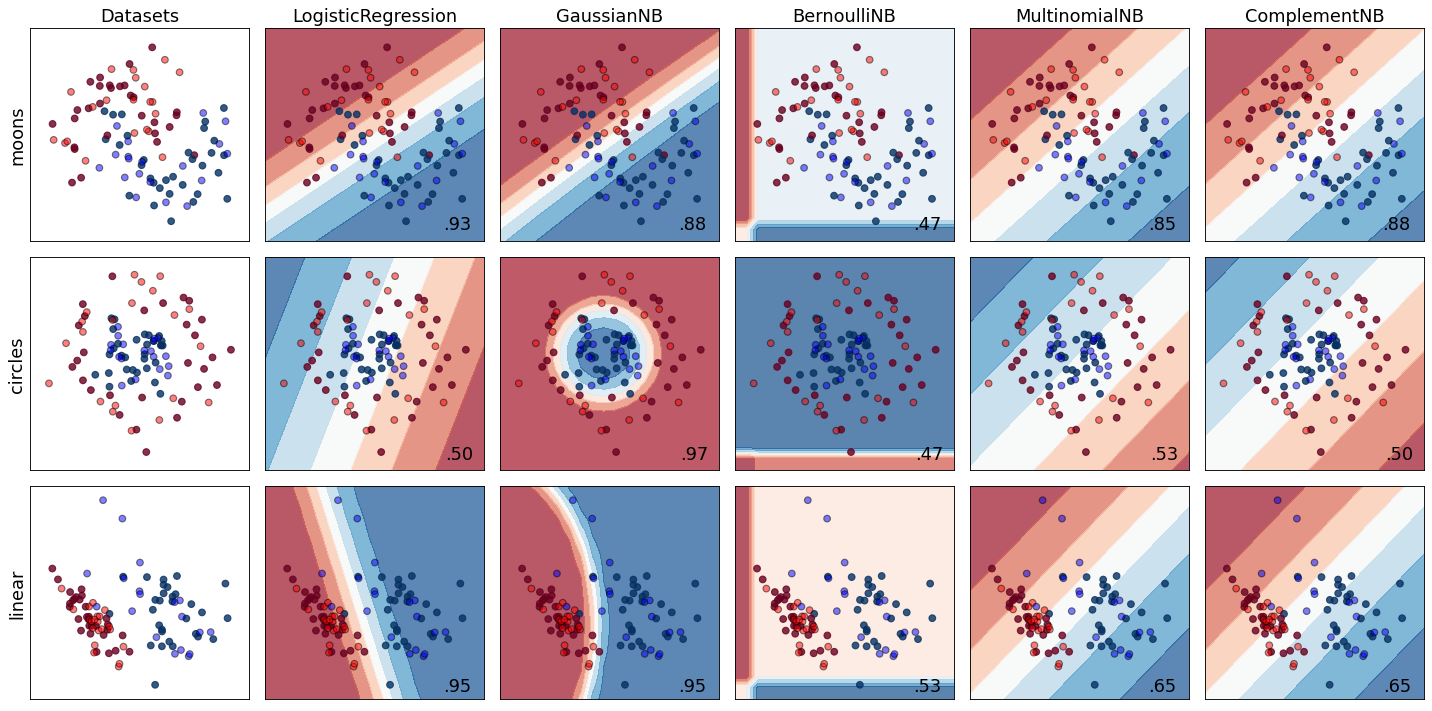

In [6]:
DecisionBoundaryDisplay(datasets,classifiers)

作为一个综合的分析，从上面的结果，我们可以看到：
* **逻辑回归**模型是一种**线性模型**，因为本质上我们只做了 $x\beta$ 的内积，所以它在**线性可分**的场合下性能良好，但在`circles`这种**非线性场景下就完全失去了分类能力**（**正确率接近50%等于瞎猜**）
    * **线性可分**指对于某个二分类数据集，我们能够利用一条直线，就将两类数据分隔开
* **GaussianNB**对数据做出的正态分布假设在各种数据分布下的效果都还不错，由于`moons`数据的分布与正态分布的差距较大，因此方法在测试集上的准确率最低
* 对于**BernoulliNB**而言。由于三个数据的分布完全**不符合模型两点分布的假设**，所以该模型在任何数据集上性能都**近乎随机猜测**
* 对于**MultinomialNB**和**ComplementNB**，有些数据（例如`moons`）的分布**近似满足模型对数据分布的假设**，此时模型的性能还不错
* 对于大部分模型，从它们的**决策边界**看到，它们在处理**近似线性可分**问题时的性能都还不错，但面对**完全非线性**问题时，例如`circles`数据集，大部门模型完全失效，只有**GaussianNB**具有预测能力，**因为它的决策边界可以是非线性的**

进一步思考，既然这些模型缺乏**非线性特征的学习能力**，那么**在不改变模型的情况下，能通过什么方法提高模型处理非线性问题时的能力吗**？我们在练习部分留出探索空间

----

## **练习**

1. 从偏差-方差分解分析的角度，你认为朴素贝叶斯是**低方差模型**还是**高方差模型**？这意味着它是否容易**过拟合**？

2. 我们在贝叶斯决策的框架下考虑**二分类问题**，即 $\mathcal{Y}=\{0,1\}$，并令后验概率 $\eta(x) = P(Y=1|x)$，根据贝叶斯决策理论，决策函数取后验概率的极大值点，所以最优决策函数 $f^*$ 为：

$$
f^*(x) = \left\{
\begin{array}{ll}
1, & \eta(x) > 1 - \eta(x)\\
0, & \eta(x) \leq 1 - \eta(x)
\end{array}
\right.
$$

对最优分类器 $f^*$ 和 **0-1损失**，我们称 $R^* = R_{\exp}(f^*) = \mathbb{E}\left[ L(y,f^*(x)) \right]$ 为**Bayes Error**

* (1) 证明：Bayes Error $R^*$满足：
$$
R^* = \frac{1}{2} - \frac{1}{2}\mathbb{E}\left[ |2\eta(x) - 1| \right]
$$
* (2) 证明：对任意决策函数 $f$，在**0-1损失**之下，**Excess Risk**有：
$$
R_{exp}(f) - R_{exp}(f^*) = R_{exp}(f) - R^* = \mathbb{E}\left[ \mathbb{I}\left( f(x)\ne f^*(x) \right)\cdot |2\eta(x) - 1| \right]
$$
从而，在**0-1损失**下，任何**非贝叶斯最优决策函数 $f$ 的理论性能都会更差**

3. 在可视化决策边界的函数`DecisionBoundaryDisplay()`中，我们注释了两段代码：

```python
# 添加二次项
X_square = np.vstack([X[:,0]**2,X[:,1]**2,X[:,0]*X[:,1]]).T
X = np.hstack([X,X_square])
```

在子函数`plot_boundary()`中，有相同功能的一段代码：

```python
# 添加二次项
data_square = np.vstack([data[:,0]**2,data[:,1]**2,data[:,0]*data[:,1]]).T
data = np.hstack([data,data_square])
```

这两段代码能够将输入特征的二次项 $x_1^2,x_2^2$ 和它们的交叉项 $x_1x_2$ 加入到模型的学习过程中，请**取消这两段代码的注释**，然后**重新可视化各个模型的决策边界**，查看结果：

```python
DecisionBoundaryDisplay(datasets,classifiers)
```

根据运行结果，尝试回答：
* 决策边界发生了什么样的变化？尤其是对于**逻辑回归**而言？
* 各个模型在测试集上的准确率发生了什么变化？模型有提升吗？
* 尝试理解上述实验的结果，对你有什么启发？

4. 在**SODE**建模中，简述如何用**K折交叉验证**来选择模型的超父 $pa$

----